### Train and tune LGBM using ADS ADSTuner

see: https://accelerated-data-science.readthedocs.io/en/latest/user_guide/model_training/ads_tuner.html#

* applicato al caso **customer churn**
* usa: generalml_ come ambiente conda

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import imblearn

from sklearn.metrics import classification_report
from sklearn.metrics import get_scorer, make_scorer, f1_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# added to handle with Sklearn pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder

# ADS tuner
from ads.hpo.distributions import *
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *

# to rebalance
from imblearn.over_sampling import RandomOverSampler

from utils import (cat_cols_selector,
                  num_cols_selector,
                  plot_cm,
                  evaluate_metrics)

%matplotlib inline

#### Legge i dati dall'Object Storage

In [2]:
NAMESPACE = "frqap2zhtzbe"
BUCKET = "WORKSHOP"
NOME_FILE = "customer_churn_data.csv"

URL = f"oci://{BUCKET}@{NAMESPACE}/{NOME_FILE}"

orig_df = pd.read_csv(URL)

orig_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Data Preparation, Feature Engineering

In [3]:
# get rid of some columns
cols_to_drop = ['customerID', 'TotalCharges']

df = orig_df.drop(columns=cols_to_drop)

TARGET = "Churn"
features = list(set(df.columns) - set([TARGET]))

In [4]:
# identify categorical and continuous
cat_cols = cat_cols_selector(df, TARGET)
num_cols = num_cols_selector(df, TARGET)

In [5]:
# code categorical as integer for LightGBM
enc = OrdinalEncoder()
enc.fit(df[cat_cols])

df[cat_cols] = enc.transform(df[cat_cols])

for col in cat_cols:
    df[col] = df[col].astype("category")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   category
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

In [7]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,29.85,No
1,1.0,0.0,0.0,0.0,34,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,56.95,No
2,1.0,0.0,0.0,0.0,2,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,53.85,Yes
3,1.0,0.0,0.0,0.0,45,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,42.30,No
4,0.0,0.0,0.0,0.0,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,70.70,Yes


#### Train/test split

In [8]:
# train, test split (lo faccio direttamente sui dataframe)
SEED = 42

TEST_FRAC = 0.2

df_train, df_test = train_test_split(df, shuffle=True, test_size=TEST_FRAC, 
                                     random_state = SEED)

X_train, y_train = df_train.drop([TARGET], axis=1), df_train[TARGET]
X_test, y_test = df_test.drop([TARGET], axis=1), df_test[TARGET]

print("# of samples in train set", df_train.shape[0])
print("# of samples in test set", df_test.shape[0])

print()
print(f'Numerical columns: {num_cols} ({len(num_cols)})')
print()
print(f'Categorical columns: {cat_cols} ({len(cat_cols)})')

# of samples in train set 5634
# of samples in test set 1409

Numerical columns: ['tenure', 'MonthlyCharges'] (2)

Categorical columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'] (16)


#### HPO sul dataset non bilanciato

In [9]:
#
# definisco la pipeline completa
#
scorer = make_scorer(accuracy_score)

N_TRIALS = 50

params = {
    # info
    "verbose" : 0,
}

# qui definisco la strategia per HPO
strategy = {"num_leaves" : IntUniformDistribution(5, 24, 1),
           'max_depth': IntUniformDistribution(2, 10, 1),
            'n_estimators': IntUniformDistribution(50, 200, 10),
            'learning_rate' : LogUniformDistribution(low=1e-03, high=1e-1),
            }

# non abbiamo bisogno di scalare perchè è un GBM
model = lgb.LGBMClassifier(**params)

In [10]:
tuner = ADSTuner(model, cv=5, n_jobs=2, strategy=strategy, scoring=scorer, random_state=SEED)

tuner.tune(X_train, y_train, exit_criterion=[NTrials(N_TRIALS)])

[I 2023-03-22 09:19:20,341] A new study created in RDB with name: hpo_467ac277-6dc2-4491-b199-cf4056e873ff


In [21]:
print(f"Number of trials launched: {len(tuner.trials)}")

Number of trials launched: 50


In [23]:
tuner.trials.sort_values(by=["value"], ascending=False).head()

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,params_num_leaves,user_attrs_mean_fit_time,...,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
38,38,0.802271,2023-03-22 09:21:53.575786,2023-03-22 09:22:00.449374,0 days 00:00:06.873588,0.024363,7,190,6,1.302443,...,accuracy_score,0.815439,0.810115,0.794144,0.792369,0.799290,0.031560,0.002777,0.009032,COMPLETE
34,34,0.801916,2023-03-22 09:21:44.062865,2023-03-22 09:21:48.915246,0 days 00:00:04.852381,0.060853,10,160,5,0.901649,...,accuracy_score,0.817214,0.810115,0.794144,0.790594,0.797513,0.013087,0.003345,0.010092,COMPLETE
27,27,0.801739,2023-03-22 09:21:03.745658,2023-03-22 09:21:11.375348,0 days 00:00:07.629690,0.034771,10,150,9,1.451851,...,accuracy_score,0.811890,0.804791,0.799468,0.792369,0.800178,0.007634,0.002870,0.006446,COMPLETE
25,25,0.801385,2023-03-22 09:20:56.894115,2023-03-22 09:21:03.726064,0 days 00:00:06.831949,0.055427,10,190,6,1.288160,...,accuracy_score,0.816327,0.808341,0.789707,0.790594,0.801954,0.060752,0.002684,0.010245,COMPLETE
19,19,0.801207,2023-03-22 09:20:36.765454,2023-03-22 09:20:43.633242,0 days 00:00:06.867788,0.025887,8,170,7,1.302826,...,accuracy_score,0.811890,0.811003,0.791482,0.791482,0.800178,0.006779,0.003653,0.008948,COMPLETE


In [24]:
tuner.status

<State.COMPLETED: 5>

In [25]:
tuner.best_params

{'learning_rate': 0.02436326428864379,
 'max_depth': 7,
 'n_estimators': 190,
 'num_leaves': 6}

#### Addestriamo il modello con i best params

In [26]:
params = tuner.best_params

model = lgb.LGBMClassifier(**params)

In [27]:
model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.02436326428864379, max_depth=7, n_estimators=190,
               num_leaves=6)

#### Evaluation

In [28]:
metrics = evaluate_metrics(model, X_test, y_test)

Validation set result:
{'accuracy': 0.8126, 'roc_auc': 0.8625}


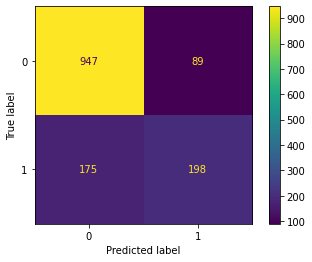

In [29]:
plot_cm(model, X_test, y_test)

#### Rebalance: vediamo che bilanciando il dataset si ottiene un risultato migliore riducendo i FN

In [30]:
SEED = 42

ros = RandomOverSampler(random_state=SEED)

In [31]:
# bilanciamo solo il training set, il test set NON è toccato
X_train_reb, y_train_reb = ros.fit_resample(X_train, y_train)

In [32]:
params = {
    # info
    "verbose" : 0,
}

strategy = {"num_leaves" : IntUniformDistribution(15, 24, 1),
            'max_depth': IntUniformDistribution(5, 15, 1),
            'n_estimators': IntUniformDistribution(50, 200, 10),
            'learning_rate' : LogUniformDistribution(low=1e-03, high=1e-1),
            }

model = lgb.LGBMClassifier(**params)

In [33]:
tuner = ADSTuner(model, cv=5, n_jobs=2, strategy=strategy, scoring=scorer, random_state=SEED) ## cv is cross validation splits

tuner.tune(X_train_reb, y_train_reb, exit_criterion=[NTrials(50)])

In [53]:
print(f"Number of trials launched: {len(tuner.trials)}")

Number of trials launched: 50


In [54]:
tuner.trials.sort_values(by=["value"], ascending=False).head(10)

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,params_num_leaves,user_attrs_mean_fit_time,...,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
32,32,0.833861,2023-03-22 09:32:37.859159,2023-03-22 09:32:59.293143,0 days 00:00:21.433984,0.099133,15,140,24,4.184779,...,accuracy_score,0.804348,0.822356,0.839879,0.849547,0.853172,0.564471,0.008301,0.018213,COMPLETE
13,13,0.831080,2023-03-22 09:30:14.073412,2023-03-22 09:30:31.404715,0 days 00:00:17.331303,0.099875,13,140,24,3.391789,...,accuracy_score,0.811594,0.830816,0.824169,0.836254,0.852568,0.049587,0.005511,0.013535,COMPLETE
22,22,0.828423,2023-03-22 09:31:25.933181,2023-03-22 09:31:41.881432,0 days 00:00:15.948251,0.098378,15,130,24,3.107639,...,accuracy_score,0.798309,0.821752,0.832628,0.836858,0.852568,0.013544,0.002589,0.018018,COMPLETE
12,12,0.827818,2023-03-22 09:30:01.052557,2023-03-22 09:30:18.394366,0 days 00:00:17.341809,0.088647,14,140,24,3.393383,...,accuracy_score,0.806159,0.821148,0.830211,0.829003,0.852568,0.073365,0.004492,0.015055,COMPLETE
14,14,0.827698,2023-03-22 09:30:18.414691,2023-03-22 09:30:35.651652,0 days 00:00:17.236961,0.094737,15,140,24,3.369716,...,accuracy_score,0.801932,0.817523,0.826586,0.840483,0.851964,0.024575,0.002097,0.017441,COMPLETE
15,15,0.827335,2023-03-22 09:30:31.423401,2023-03-22 09:30:47.272605,0 days 00:00:15.849204,0.092830,14,130,24,3.094140,...,accuracy_score,0.802536,0.821148,0.832024,0.829003,0.851964,0.023186,0.003466,0.016029,COMPLETE
34,34,0.826367,2023-03-22 09:32:59.315599,2023-03-22 09:33:18.699550,0 days 00:00:19.383951,0.098947,14,130,23,3.769775,...,accuracy_score,0.809783,0.819335,0.825378,0.832628,0.844713,0.421348,0.003947,0.011843,COMPLETE
47,47,0.826247,2023-03-22 09:34:52.125041,2023-03-22 09:35:07.602167,0 days 00:00:15.477126,0.095747,14,130,23,3.023074,...,accuracy_score,0.806159,0.815710,0.825982,0.835650,0.847734,0.024145,0.004393,0.014593,COMPLETE
46,46,0.825643,2023-03-22 09:34:47.789926,2023-03-22 09:35:03.292787,0 days 00:00:15.502861,0.097433,14,130,23,3.021967,...,accuracy_score,0.801329,0.823565,0.832628,0.825378,0.845317,0.034776,0.002258,0.014363,COMPLETE
23,23,0.825039,2023-03-22 09:31:38.056829,2023-03-22 09:31:53.970326,0 days 00:00:15.913497,0.095491,15,130,24,3.109173,...,accuracy_score,0.804348,0.809063,0.827190,0.836858,0.847734,0.013020,0.005430,0.016387,COMPLETE


In [55]:
tuner.best_params

{'learning_rate': 0.09913346227583475,
 'max_depth': 15,
 'n_estimators': 140,
 'num_leaves': 24}

In [56]:
params = tuner.best_params

model = lgb.LGBMClassifier(**params)

In [57]:
model.fit(X_train_reb, y_train_reb)

LGBMClassifier(learning_rate=0.09913346227583475, max_depth=15,
               n_estimators=140, num_leaves=24)

In [58]:
metrics = evaluate_metrics(model, X_test, y_test)

Validation set result:
{'accuracy': 0.7757, 'roc_auc': 0.8528}


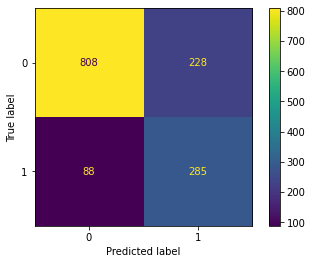

In [59]:
plot_cm(model, X_test, y_test)

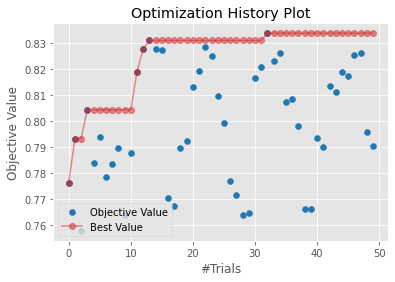

In [60]:
tuner.plot_best_scores()

In [61]:
tuner.search_space()

{'num_leaves': IntUniformDistribution(low=15, high=24, step=1),
 'max_depth': IntUniformDistribution(low=5, high=15, step=1),
 'n_estimators': IntUniformDistribution(low=50, high=200, step=10),
 'learning_rate': LogUniformDistribution(low=0.001, high=0.1)}

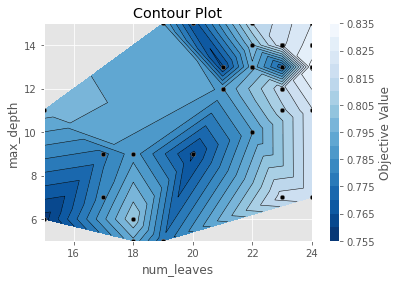

In [62]:
tuner.plot_contour_scores(params=['num_leaves', 'max_depth'])